In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob 
from keras.models import model_from_json

from evaluate.lane import LaneEval
import cv2
import json
import time
import os

Using TensorFlow backend.


# Load Models

In [2]:
json_file = open("lanes_CNN_model.json", "r")
json_model = json_file.read()
json_file.close()
lanes_model = model_from_json(json_model)
lanes_model.load_weights("lanes_CNN_model.h5")
print("Lane Model loaded")
lanes_model.summary()


Lane Model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 80, 160, 3)        12        
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 158, 60)       1680      
_________________________________________________________________
Conv2 (Conv2D)               (None, 76, 156, 50)       27050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 78, 50)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 36, 76, 40)        18040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 76, 40)        0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 34, 74, 30)        108

In [3]:
### LOAD HERE POLYNOMIAL MODEL

In [4]:
def _maskThresh(S_channel, low_limit=0, high_limit=255):
    """Takes single channel, outputs binary image"""
    s_binary=np.zeros_like(S_channel, dtype=np.uint8)
    s_binary[(S_channel>=low_limit) & (S_channel<=high_limit)]=1
    return s_binary

def denormalize(evaluation):
    """Inverse of normalization from model"""
    #Get channel from model
    chan=evaluation[0]
    #Normalize 0-1, get in range 255
    normalizer=np.max(chan)
    chan=255*chan/normalizer
    chan=np.uint8(chan)
    zeros=np.zeros_like(chan)
    augmented=255*_maskThresh(chan, 15,255)
    image=cv2.merge((zeros, augmented, zeros))
    #image=cv2.merge((zeros, chan, zeros))
    return image

def road_lanes(image):
    """Takes road Image, rezises for model, predicts
    Returns Green lane markings, overlapped image,
    elapsed time"""
    t1=time.time()
    img=image
    #Preprocess
    img = cv2.resize(img, None,fx=0.125, fy=0.125)
    scaled_size=np.zeros_like(img)
    #Crop image
    img=img[10:,:,:]
    img[:11,:,:]=0
    #Conditioning for model
    small_img=np.asarray(img)
    small_img=np.float32(small_img)
    small_img = small_img[None,:,:,:]
    #Get prediction
    prediction=lanes_model.predict(small_img)
    mask=denormalize(prediction)
    kernel = np.ones((3,3),np.uint8)
    #mask = cv2.erode(mask,kernel,iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    scaled_size[10:,:,:]=mask
    scaled_size = cv2.resize(scaled_size, None, fx=8, fy=8)
    total_time=time.time()-t1
    full=np.zeros_like(image)
    
    
    #overlay=cv2.addWeighted(mask,0.5, img,0.5,0)
    overlay=cv2.addWeighted(scaled_size,0.5, image,0.5,0)
    
    return img, mask, overlay, total_time
    
    

# Evaluation Example

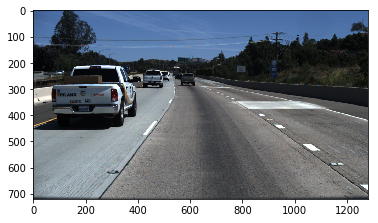

uint8


In [5]:
img=mpimg.imread("train_set/clips/0531/1492626287507231547/20.jpg")

plt.imshow(img)
plt.show()
print(img.dtype)

Elapsed time:  1.822352409362793


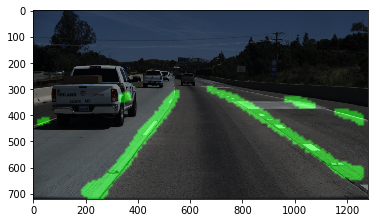

In [6]:
original, predicted, result, elapsed =road_lanes(img)
print("Elapsed time: ", elapsed)
image=denormalize(result)
plt.imshow(result)
plt.show()


# Load Image files

In [7]:
data_path = "test_set/"
json_test = [json.loads(line) for line in open('test_set/test_tasks_0627.json')]
total_test_data=len(json_test)
print("Total Test Data: ", total_test_data)
def _get_data(json_list, index):
    """Reads data from json"""
    data = json_list[index]
    lanes = data['lanes']
    y_samples = data['h_samples']
    raw_file = data['raw_file']
    return [raw_file, lanes, y_samples]

def generate_predictions(data, input_path="test_set/", debbug=False, output_dir="out_img/predicted/", save_big_mask= False):
    """Takes data read from json, ouputs predicted mask"""
    #Naming convention
    path = os.path.dirname(data[0])
    name = os.path.basename(path)
    #Read Image
    img = mpimg.imread(input_path +data[0])
    
    #Predict
    original, predicted, result, elapsed =road_lanes(img)
    
    if save_big_mask:
        print("save_big_mask not implemented!")
        """
        scaled_size=np.zeros_like((90,160,3))
        scaled_size[10:,:,:]=mask
        scaled_size = cv2.resize(scaled_size, None, fx=8, fy=8)
        big
        """
    if debbug:
        mpimg.imsave(output_dir + name +"_Feed.jpg", original)
        mpimg.imsave(output_dir + name +"_Predicted.jpg", predicted)
        mpimg.imsave(output_dir + name +"_Result.jpg", result)
    
    return original, predicted, result, elapsed
        

Total Test Data:  2782


Working on data:  0 / 2782
Working on data:  250 / 2782
Working on data:  500 / 2782
Working on data:  750 / 2782
Working on data:  1000 / 2782
Working on data:  1250 / 2782
Working on data:  1500 / 2782
Working on data:  1750 / 2782
Working on data:  2000 / 2782
Working on data:  2250 / 2782
Working on data:  2500 / 2782
Working on data:  2750 / 2782
All data predicted
Total data:  2782
Total Time:  31.5277113914


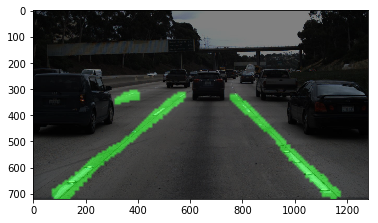

In [8]:
x = []
elapsed_time = []
prediction=[]

for i in range(len(json_test)):
#for i in range(3):
    test_data = _get_data(json_test,i)
    img, mask, overlay, elapsed = generate_predictions(test_data, debbug=False)
    if (i%250 == 0):
        print("Working on data: ", i, "/", total_test_data)
    x.append(img)
    prediction.append(mask)
    elapsed_time.append(elapsed)
   
print("All data predicted")
print("Total data: ", len(x))
print("Total Time: ", np.sum(elapsed_time))
plt.imshow(overlay)
plt.show()

In [9]:
import pickle
data = {"Feed": x, "Pred": prediction, "Speed": elapsed_time}
pickle.dump(data, open("predicted_data/test_predictions.p", "wb"))
print("Data Saved!")
print("Execute Estimation now...")

Data Saved!
Execute Estimation now...
